### Prerequsite - Upgrade Scikit Learn
The current workspace has scikit-learn v0.19.1 installed. However, you can upgrade scikit-learn to 0.24.x. and use this [OneHotEncoder](https://scikit-learn.org/0.21/modules/generated/sklearn.preprocessing.OneHotEncoder.html) library. 


In [1]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.24.2.


In [ ]:
!pip install --upgrade scikit-learn

In [2]:
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

In [3]:
# Now you can import and use OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [4]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''
pd.options.display.max_rows = 200
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [5]:
# Load in the general demographics data.
azdias_gen = pd.read_csv('Udacity_AZDIAS_Subset.csv', engine='python', sep='\;')

# Load in the feature summary file.
azdias_feature = pd.read_csv('AZDIAS_Feature_Summary.csv', engine='python', sep='\;')

In [6]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias_gen.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [7]:
azdias_feature

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [8]:
azdias_gen.shape

(891221, 85)

In [9]:
unknown_chars = [-1, 'X', 'XX']

In [10]:
# Count of each column in each dataset that started out with the unknown characters
azdias_gen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

In [11]:
azdias_gen.isin(unknown_chars).sum()

AGER_TYP                 677503
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP                 0
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP               0
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN           0
LP_LEBENSPHASE_GROB           0
LP_FAMILIE_FEIN               0
LP_FAMILIE_GROB               0
LP_STATUS_FEIN                0
LP_STATUS_GROB                0
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S                0
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

In [ ]:
# Count of each column in each dataset that started out NaN

In [12]:
azdias_gen.isna().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

In [13]:
# Identify missing or unknown data values and convert them to NaNs.

# Convert entries in 'missing_or_unknown' column from strings to lists

lists = azdias_feature['missing_or_unknown']
result_list = []
for i in lists:
    result = i.lstrip('[')
    result = result.rstrip(']')
    result = result.split(',')
    result_list.append(result)
azdias_feature['unknown_converted'] = pd.Series(result_list)

In [14]:
azdias_gen.replace(unknown_chars, np.nan, inplace=True)

In [15]:
azdias_gen['ALTERSKATEGORIE_GROB'].replace(0, np.nan, inplace=True)

In [16]:
azdias_gen['ANREDE_KZ'].replace(0, np.nan, inplace=True)

In [17]:
azdias_gen['CJT_GESAMTTYP'].replace(0, np.nan, inplace=True)

In [18]:
azdias_gen['HEALTH_TYP'].replace(0, np.nan, inplace=True)

In [19]:
azdias_gen['LP_FAMILIE_GROB'].replace(0, np.nan, inplace=True)

In [20]:
azdias_gen['PRAEGENDE_JUGENDJAHRE'].replace(0, np.nan, inplace=True)

In [21]:
azdias_gen['RETOURTYP_BK_S'].replace(0, np.nan, inplace=True)

In [22]:
azdias_gen['ALTER_HH'].replace(0, np.nan, inplace=True)

In [23]:
azdias_gen['HH_EINKOMMEN_SCORE'].replace(0, np.nan, inplace=True)

In [24]:
azdias_gen['W_KEIT_KIND_HH'].replace(0, np.nan, inplace=True)

In [25]:
azdias_gen['WOHNDAUER_2008'].replace(0, np.nan, inplace=True)

In [26]:
azdias_gen['KKK'].replace(0, np.nan, inplace=True)

In [27]:
azdias_gen['REGIOTYP'].replace(0, np.nan, inplace=True)

In [28]:
azdias_gen['ALTER_HH'].replace(0, np.nan, inplace=True)

In [29]:
azdias_gen['ARBEIT'].replace(9, np.nan, inplace=True)

In [30]:
azdias_gen['RELAT_AB'].replace(9, np.nan, inplace=True)

In [31]:
# Investigate patterns in the amount of missing data in each column.
missing_data_in_df_gen=pd.DataFrame({'NaN_Counts': azdias_gen.isna().sum(), 'NaN_Proportions(%)': (azdias_gen.isna().sum() / azdias_gen.shape[0]) * 100}).sort_values(by='NaN_Proportions(%)', ascending=False)
missing_data_in_df_gen[missing_data_in_df_gen['NaN_Proportions(%)'] > 9]

# Source: https://stackoverflow.com/questions/72083258/how-to-plot-distribution-of-missing-values-in-a-dataframe

,NaN_Counts,NaN_Proportions(%)
AGER_TYP,677503,76.019640
KK_KUNDENTYP,584612,65.596749
ALTER_HH,310267,34.813699
KKK,158064,17.735668
REGIOTYP,158064,17.735668
W_KEIT_KIND_HH,147988,16.605084
KBA05_ANTG1,133324,14.959701
MOBI_REGIO,133324,14.959701
KBA05_GBZ,133324,14.959701
KBA05_BAUMAX,133324,14.959701


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

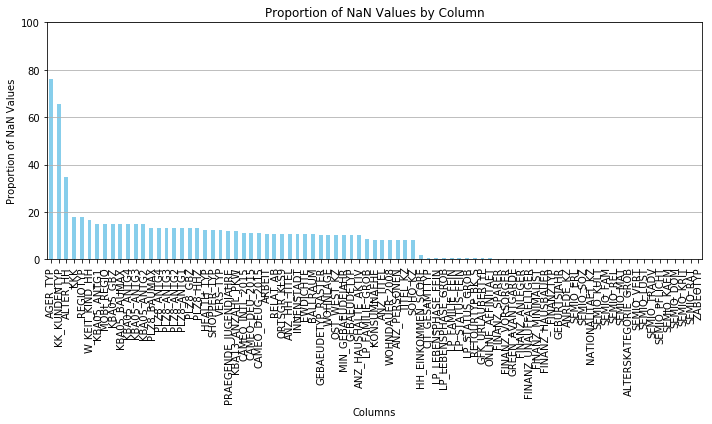

In [32]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

plt.figure(figsize=(10, 6))
missing_data_in_df_gen['NaN_Proportions(%)'].plot(kind='bar', color='skyblue')
plt.title('Proportion of NaN Values by Column')
plt.xlabel('Columns')
plt.ylabel('Proportion of NaN Values')
plt.xticks(rotation=90)
plt.ylim(0, 100)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [33]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

azdias_gen = azdias_gen.loc[:, azdias_gen.columns.difference(['TITEL_KZ', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'AGER_TYP', 
                 'GEBURTSJAHR', 'LP_LEBENSPHASE_FEIN', 
                 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN',
                 'NATIONALITAET_KZ'])]

#### Discussion 1.1.2: Assess Missing Data in Each Column####

AGER_TYP is a field that tracks what type of elderly person each person is.  Based on the fact that this field is NaN over 76% in the general population dataset and over 50% in the customer dataset, it's clear that either the population is generally not elderly or that this information was not captured.  The customer base is more likely to be elderly than not.

KK_KUNDENTYP is a field for tracking consumer patterns over the last 12 months, but that information was unknown for over 50% of people in each dataset.

TITEL_KZ shows if a person is a doctor of academia.  Over 99% of people in each dataset were not doctors.

KBA05_BAUMAX is the most common housing type in a given microcell.  That statistic is also unknown for over 50% of people.

GEBURTSJAHR is the year of birth of the user, but it, too, is missing for almost 50% of people.

LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB are classifications of life stages at the fine and rough scales, respectively.  These have more detailed than needed for our analysis.

LP_FAMILIE_FEIN and LP_STATUS_FEIN are fine classifications of family and social status, respectively.  These have more detailed than needed for our analysis.

NATIONALITAET_KZ is for nationality of surname which should not matter in the analysis.

GEBAEUDETYP is for type of building family lives in, which should not matter for the analysis we're doing.

CAMEO_DEU_2015 and CAMEO_DEUG_2015 are for wealth and life stage typology.  CAMEO_INTL_2015 is going to be analyzed, so no need for the other two categories.

The family and social variables relate to each other, but none of the other variables do.

*Columns Dropped:*  
-TITEL_KZ  
-KK_KUNDENTYP  
-KBA05_BAUMAX  
-AGER_TYP  
-GEBURTSJAHR  
-LP_LEBENSPHASE_FEIN  
-LP_LEBENSPHASE_GROB  
-LP_FAMILIE_FEIN  
-LP_STATUS_FEIN  
-NATIONALITAET_KZ  
-GEBAEUDETYP  
-CAMEO_DEUG_2015  
-CAMEO_DEU_2015  
-GEBAEUDETYP_RASTER  

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [34]:
# How much data is missing in each row of the dataset?
threshold = 0
missing_gen = azdias_gen.isna().sum(axis=1)

In [35]:
azdias_gen['missing_values'] = missing_gen

In [36]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
subset_with_missing_gen = azdias_gen.loc[missing_gen > threshold]
subset_without_missing_gen = azdias_gen.loc[missing_gen <= threshold]

#### Discussion 1.1.3: Assess Missing Data in Each Row

Yes, the dataset with a lot of missing values in each row is qualtatively poorer than the one with few or no missing values.  This usually means that either the methods of data collection were poor, or the attention to entering the data in the dataset were inadequate.  This will result in the analysis of that dataset compared to a more complete dataset to be biased.  This is why I chose the threshold of no more than 3 empty values per row to be included in the dataset I will end up analyzing.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [37]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical_columns_gen = subset_without_missing_gen.select_dtypes(include=['object', 'category']).columns

print("Categorical Variables - General:", categorical_columns_gen)

Categorical Variables - General: Index(['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'OST_WEST_KZ'], dtype='object')


In [38]:
for col in categorical_columns_gen:
    unique_values = subset_without_missing_gen[col].unique()
    num_unique = len(unique_values)
    print(f"Column: {col}")
    print(f"Unique Values: {unique_values}")
    print(f"Number of Unique Values: {num_unique}")

    if num_unique == 2:
        print("This is a binary categorical variable.")
    elif num_unique > 2:
        print("This is a multi-level categorical variable.")
    else:
        print("This variable has no meaningful categories.")
    print()  # Print a newline for better readability


Column: CAMEO_DEUG_2015
Unique Values: ['4' '6' '8' '2' '1' '9' '3' '7' '5']
Number of Unique Values: 9
This is a multi-level categorical variable.

Column: CAMEO_DEU_2015
Unique Values: ['4C' '6B' '8C' '2D' '1A' '1E' '9D' '9B' '1B' '8B' '4E' '3C' '7A' '3D'
 '5A' '4A' '7B' '9A' '6E' '6D' '5C' '9C' '7D' '5E' '1D' '8D' '8A' '4D'
 '3A' '6C' '9E' '4B' '2B' '2A' '7C' '5D' '6F' '5B' '2C' '5F' '1C' '6A'
 '7E' '3B']
Number of Unique Values: 44
This is a multi-level categorical variable.

Column: CAMEO_INTL_2015
Unique Values: ['24' '43' '54' '14' '13' '15' '51' '41' '25' '31' '22' '52' '45' '35'
 '33' '34' '55' '23' '44' '12' '32']
Number of Unique Values: 21
This is a multi-level categorical variable.

Column: OST_WEST_KZ
Unique Values: ['W' 'O']
Number of Unique Values: 2
This is a binary categorical variable.



In [39]:
# Drop unnecessary columns

cols_to_drop = ['OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'KBA13_ANZAHL_PKW',
               'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX',
               'PLZ8_HHZ', 'PLZ8_GBZ', 'GEBAEUDETYP_RASTER', 'MOBI_REGIO', 'GEBAEUDETYP_RASTER',
               'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'KBA05_GBZ', 'KBA05_ANTG4',
               'KBA05_ANTG3', 'KBA05_ANTG2', 'KBA05_ANTG1', 'WOHNLAGE', 
               'MIN_GEBAEUDEJAHR', 'ANZ_HAUSHALTE_AKTIV', 'GEBAEUDETYP',
               'KONSUMNAEHE', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP']

subset_without_missing_gen = subset_without_missing_gen.loc[:, subset_without_missing_gen.columns.difference(cols_to_drop)]

#### Discussion 1.2.1: Re-Encode Categorical Features

I dropped the columns above due to them being too detailed and unnecessary for our analysis.  I'm keeping PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 because age, income level, and movement could make a big difference in whether or not someone becomes a customer.  I will be breaking PRAEGENDE_JUGENDJAHRE up into two new columns: Decade and Movement, to separate out the multiple levels from that column.  I will be breaking CAMEO_INTL_2015 up into two new columns: Wealth and Family, to separate out the multiple levels from that column.
I'm decoding and then re-encoding ANREDE_KZ, CJT_GESAMTTYP, FINANZTYP, GFK_URLAUBERTYP, HEALTH_TYP, LP_FAMILIE_GROB, LP_STATUS_GROB, RETOURTYP_BK_S, SHOPPER_TYP, VERS_TYP, ZABEOTYP because they are nominal categories.  The remainder not addressed are ordinal in nature and already coded as such.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [ ]:
print(pd.__version__)

In [3]:
!pip install --upgrade pandas

    100% |████████████████████████████████| 9.5MB 3.0MB/s eta 0:00:01
    100% |████████████████████████████████| 235kB 39.4MB/s ta 0:00:01
  Found existing installation: python-dateutil 2.6.1
    Uninstalling python-dateutil-2.6.1:
      Successfully uninstalled python-dateutil-2.6.1
  Found existing installation: pandas 0.23.3
    Uninstalling pandas-0.23.3:
      Successfully uninstalled pandas-0.23.3


In [40]:
# Decode nominal variables before re-encoding using OneHotEncoder

gender_map = {1: 'Male',
              2: 'Female'}
advert_map = {1: 'Advertising- and Consumptionminimalist',
              2: 'Advertising- and Consumptiontraditionalist',
              3: 'advertisinginterested Store-shopper',
              4: 'advertisinginterested Online-shopper',
              5: 'Advertising- and Cross-Channel-Enthusiast',
              6: 'Advertising-Enthusiast with restricted Cross-Channel-Behaviour'}
financial_map = {1: 'low financial interest (MINIMALIST)',
                 2: 'money-saver (SPARER)',
                 3: 'home ownership (HAUSBAUER)',
                 4: 'be prepared (VORSORGER)',
                 5: 'investor (ANLEGER)',
                 6: 'inconspicuous (UNAUFFAELLIGER)'}
vacation_map = {1: 'Event travelers',
                2: 'Family-oriented vacationists',
                3: 'Winter sportspeople',
                4: 'Culture lovers',
                5: 'Nature fans',
                6: 'Hiker',
                7: 'Golden ager',
                8: 'Homeland-connected vacationists',
                9: 'Package tour travelers',
                10: 'Connoisseurs',
                11: 'Active families',
                12: 'Without vacation'}
health_map = {1: 'critical reserved',
              2: 'sanitary affine',
              3: 'jaunty hedonists'}
family_rough_map = {1: 'single',
                    2: 'couple',
                    3: 'single parent',
                    4: 'family',
                    5: 'multiperson household'}
social_status_map = {1: 'low-income',
                     2: 'average',
                     3: 'independents',
                     4: 'houseowners',
                     5: 'top earners'}
return_map = {1: 'influenceable',
              2: 'demanding',
              3: 'incentive-receptive',
              4: 'conservative',
              5: 'determined'}
shopper_map = {0: 'external supplied hedonists',
               1: 'Shopping-stressed',
               2: 'family-shopper',
               3: 'demanding shopper'}

In [41]:
subset_without_missing_gen['ANREDE_KZ'] = subset_without_missing_gen['ANREDE_KZ'].map(gender_map)
subset_without_missing_gen['CJT_GESAMTTYP'] = subset_without_missing_gen['CJT_GESAMTTYP'].map(advert_map)
subset_without_missing_gen['FINANZTYP'] = subset_without_missing_gen['FINANZTYP'].map(financial_map)
subset_without_missing_gen['GFK_URLAUBERTYP'] = subset_without_missing_gen['GFK_URLAUBERTYP'].map(vacation_map)
subset_without_missing_gen['HEALTH_TYP'] = subset_without_missing_gen['HEALTH_TYP'].map(health_map)
subset_without_missing_gen['LP_FAMILIE_GROB'] = subset_without_missing_gen['LP_FAMILIE_GROB'].map(family_rough_map)
subset_without_missing_gen['LP_STATUS_GROB'] = subset_without_missing_gen['LP_STATUS_GROB'].map(social_status_map)
subset_without_missing_gen['RETOURTYP_BK_S'] = subset_without_missing_gen['RETOURTYP_BK_S'].map(return_map)
subset_without_missing_gen['SHOPPER_TYP'] = subset_without_missing_gen['SHOPPER_TYP'].map(shopper_map)

In [42]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

subset_without_missing_gen['Decade'] = subset_without_missing_gen['PRAEGENDE_JUGENDJAHRE']
subset_without_missing_gen['Decade'].replace([1, 2], 1, inplace=True)
subset_without_missing_gen['Decade'].replace([3, 4], 2, inplace=True)
subset_without_missing_gen['Decade'].replace([5, 6, 7], 3, inplace=True)
subset_without_missing_gen['Decade'].replace([8, 9], 4, inplace=True)
subset_without_missing_gen['Decade'].replace([10, 11, 12, 13], 5, inplace=True)
subset_without_missing_gen['Decade'].replace([14, 15], 6, inplace=True)
subset_without_missing_gen['Movement'] = subset_without_missing_gen['PRAEGENDE_JUGENDJAHRE']
subset_without_missing_gen['Movement'].replace([1, 3, 5, 8, 10, 12, 14], 0, inplace=True)
subset_without_missing_gen['Movement'].replace([2, 4, 6, 7, 9, 11, 13, 15], 1, inplace=True)

In [43]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

subset_without_missing_gen['Wealth'] = subset_without_missing_gen['CAMEO_INTL_2015']
subset_without_missing_gen['Wealth'].replace(['11', '12', '13', '14', '15'], 1, inplace=True)
subset_without_missing_gen['Wealth'].replace(['21', '22', '23', '24', '25'], 2, inplace=True)
subset_without_missing_gen['Wealth'].replace(['31', '32', '33', '34', '35'], 3, inplace=True)
subset_without_missing_gen['Wealth'].replace(['41', '42', '43', '44', '45'], 4, inplace=True)
subset_without_missing_gen['Wealth'].replace(['51', '52', '53', '54', '55'], 5, inplace=True)
subset_without_missing_gen['Family'] = subset_without_missing_gen['CAMEO_INTL_2015']
subset_without_missing_gen['Family'].replace(['11', '21', '31', '41', '51'], 1, inplace=True)
subset_without_missing_gen['Family'].replace(['12', '22', '32', '42', '52'], 2, inplace=True)
subset_without_missing_gen['Family'].replace(['13', '23', '33', '43', '53'], 3, inplace=True)
subset_without_missing_gen['Family'].replace(['14', '24', '34', '44', '54'], 4, inplace=True)
subset_without_missing_gen['Family'].replace(['15', '25', '35', '45', '55'], 5, inplace=True)

In [44]:
# Decode the new variables created from PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 so they can be re-encoded using OneHotEncoder

decade_map = {1.0: '40s',
              2.0: '50s',
              3.0: '60s',
              4.0: '70s',
              5.0: '80s',
              6.0: '90s'}
movement_map = {0.0: 'mainstream',
                1.0: 'avantgarde'}
wealth_map = {1.0: 'Wealthy Households',
              2.0: 'Prosperous Households',
              3.0: 'Comfortable Households',
              4.0: 'Less Affluent Households',
              5.0: 'Poorer Households'}
family_map = {1.0: 'Pre-Family Couples & Singles',
              2.0: 'Young Couples With Children',
              3.0: 'Families With School Age Children',
              4.0: 'Older Families &  Mature Couples',
              5.0: 'Elders In Retirement'}

In [45]:
subset_without_missing_gen['Decade'] = subset_without_missing_gen['Decade'].map(decade_map)
subset_without_missing_gen['Movement'] = subset_without_missing_gen['Movement'].map(movement_map)
subset_without_missing_gen['Wealth'] = subset_without_missing_gen['Wealth'].map(wealth_map)
subset_without_missing_gen['Family'] = subset_without_missing_gen['Family'].map(family_map)

In [46]:
# Re-encode categorical variable(s) to be kept in the analysis.
cat_columns = ['Decade', 'Movement', 'Wealth', 'Family', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 
              'HEALTH_TYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'RETOURTYP_BK_S', 'SHOPPER_TYP']

In [47]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [48]:
transform_gen = ohe.fit_transform(subset_without_missing_gen[cat_columns])

In [50]:
column_names = ohe.get_feature_names(cat_columns)

In [51]:
encode_gen = pd.DataFrame(transform_gen, columns=column_names)

In [52]:
concat_gen = pd.concat([subset_without_missing_gen, encode_gen], axis=1)

In [53]:
concat_gen.drop(columns=['ANREDE_KZ', 
                 'CJT_GESAMTTYP', 
                 'FINANZTYP', 
                 'CAMEO_INTL_2015', 
                 'PRAEGENDE_JUGENDJAHRE', 
                 'SEMIO_DOM',
                 'ANREDE_KZ', 
                 'CJT_GESAMTTYP', 
                 'FINANZTYP', 
                 'SEMIO_ERL',
                 'GFK_URLAUBERTYP', 
                 'HEALTH_TYP', 
                 'SEMIO_FAM', 
                 'SEMIO_KAEM',
                 'LP_FAMILIE_GROB', 
                 'LP_STATUS_GROB', 
                 'SEMIO_KRIT', 
                 'SEMIO_KULT',
                 'RETOURTYP_BK_S', 
                 'SHOPPER_TYP', 
                 'missing_values', 
                 'SEMIO_LUST',
                 'SEMIO_MAT', 
                 'SEMIO_PFLICHT', 
                 'SEMIO_RAT', 
                 'SEMIO_REL', 
                 'SEMIO_SOZ',
                 'SEMIO_TRADV', 
                 'SEMIO_VERT', 
                 'Decade', 
                 'Movement', 
                 'Wealth', 
                 'Family', 
                 'GFK_URLAUBERTYP', 
                 'HEALTH_TYP', 
                 'LP_FAMILIE_GROB',
                 'LP_STATUS_GROB', 
                 'RETOURTYP_BK_S'], axis=1, inplace=True)

In [55]:
concat_gen.isna().sum()

ALTERSKATEGORIE_GROB                                                            221398
ALTER_HH                                                                        221398
ANZ_HH_TITEL                                                                    221398
ANZ_PERSONEN                                                                    221398
ANZ_TITEL                                                                       221398
ARBEIT                                                                          221398
FINANZ_ANLEGER                                                                  221398
FINANZ_HAUSBAUER                                                                221398
FINANZ_MINIMALIST                                                               221398
FINANZ_SPARER                                                                   221398
FINANZ_UNAUFFAELLIGER                                                           221398
FINANZ_VORSORGER                           

In [57]:
concat_gen.dropna(inplace=True)
concat_gen.reset_index(drop=True, inplace=True)

In [58]:
concat_gen.isna().sum()

ALTERSKATEGORIE_GROB                                                            0
ALTER_HH                                                                        0
ANZ_HH_TITEL                                                                    0
ANZ_PERSONEN                                                                    0
ANZ_TITEL                                                                       0
ARBEIT                                                                          0
FINANZ_ANLEGER                                                                  0
FINANZ_HAUSBAUER                                                                0
FINANZ_MINIMALIST                                                               0
FINANZ_SPARER                                                                   0
FINANZ_UNAUFFAELLIGER                                                           0
FINANZ_VORSORGER                                                                0
GREEN_AVANTGARDE

#### Discussion 1.2.2: Engineer Mixed-Type Features

I decoded and re-encoded the new variables I created from CAMEO_INTL_2015 (Wealth and Family) and PRAEGENDE_JUGENDJAHRE (Decade and Movement).  I then dropped CAMEO_INTL_2015 and PRAEGENDE_JUGENDJAHRE.  The other categorical and mixed variables I dropped because they were not needed for analysis.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [59]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
features_to_scale = list(concat_gen.columns.values)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [60]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
scaled_data = scaler.fit_transform(concat_gen)
scaled_df = pd.DataFrame(scaled_data, columns=concat_gen.columns)

### Discussion 2.1: Apply Feature Scaling

Since the scales of each feature varies, it made more sense to use StandardScaler instead of MinMaxScaler so that the mean was 0 and the standard deviation was 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [61]:
# Apply PCA to the data.

from sklearn.decomposition import PCA

pca = PCA()
principal_comp = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=principal_comp, columns=features_to_scale)

In [62]:
pca_df.shape

(232291, 87)

In [63]:
# Investigate the variance accounted for by each principal component.
explained_var = pca.explained_variance_ratio_
eigenvalues = pca.explained_variance_

variance_df = pd.DataFrame({
    'Principal Component': [f'{i}' for i in features_to_scale],
    'Explained Variance Ratio': explained_var
})

In [64]:
variance_df1 = variance_df.sort_values(by='Explained Variance Ratio')

In [65]:
var_df_10 = variance_df1.tail(10)
var_df_10

,Principal Component,Explained Variance Ratio
9,FINANZ_SPARER,0.019595
8,FINANZ_MINIMALIST,0.020932
7,FINANZ_HAUSBAUER,0.021949
6,FINANZ_ANLEGER,0.025215
5,ARBEIT,0.027933
4,ANZ_TITEL,0.032639
3,ANZ_PERSONEN,0.040125
2,ANZ_HH_TITEL,0.042418
1,ALTER_HH,0.053037
0,ALTERSKATEGORIE_GROB,0.058293


In [66]:
var_df_10_list = var_df_10['Principal Component'].values.tolist()

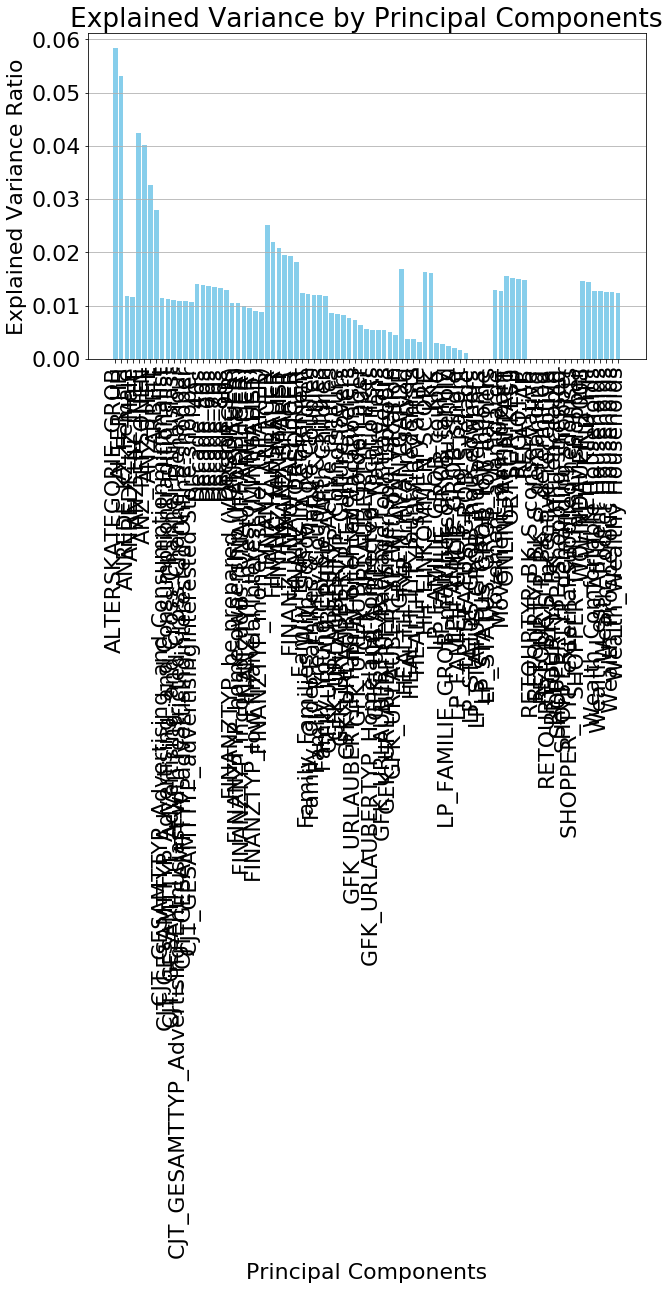

In [67]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(10, 6))
plt.bar(variance_df['Principal Component'], variance_df['Explained Variance Ratio'], color='skyblue')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

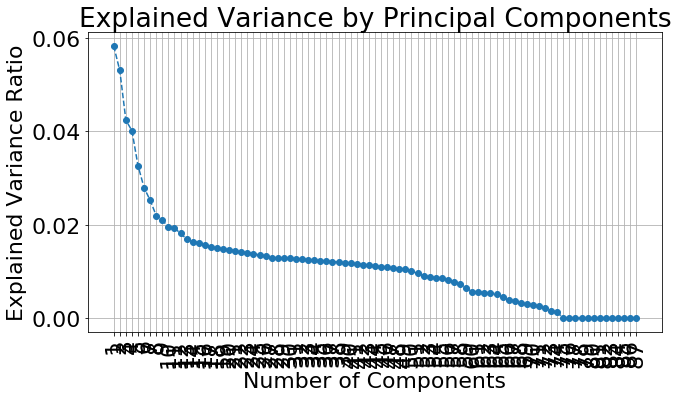

In [68]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_var) + 1), explained_var, marker='o', linestyle='--')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_var) + 1), rotation=90)
plt.grid()
plt.tight_layout()
plt.show()

In [69]:
# Re-apply PCA to the data while selecting for number of components to retain.
n_components=10

pca = PCA(n_components=n_components)
principal_comp = pca.fit_transform(scaled_data)

### Discussion 2.2: Perform Dimensionality Reduction

After plotting explained variance of all features, I determined that elbow of the screen plot is at point 4, meaning the amount of variance starts to level out at that point, so that's the number of transformed features I'm retaining for the next step.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [71]:
def interpret_features(component_n):
    
    feature_names = concat_gen.columns
    weights = pca.components_[component_n]
    
    # Create a DataFrame to map feature names to their weights
    weights_df = pd.DataFrame({
        'Feature': feature_names,
        'Weight': weights
    })
    
    # Sort the DataFrame by absolute weight values
    sorted_weights_df = weights_df.reindex(weights_df['Weight'].abs().sort_values(ascending=False).index)
    
    # Print the sorted weights
    print(sorted_weights_df)

In [72]:
# Get the weights of the first principal component
interpret_features(0)

                                              Feature    Weight
9                                       FINANZ_SPARER  0.410261
11                                   FINANZ_VORSORGER -0.383069
6                                      FINANZ_ANLEGER  0.357053
10                              FINANZ_UNAUFFAELLIGER  0.344863
1                                            ALTER_HH  0.332783
0                                ALTERSKATEGORIE_GROB -0.332618
8                                   FINANZ_MINIMALIST -0.296607
15                                  ONLINE_AFFINITAET  0.191559
20                                     W_KEIT_KIND_HH -0.183295
19                                     WOHNDAUER_2008 -0.149073
13                                 HH_EINKOMMEN_SCORE  0.119935
12                                   GREEN_AVANTGARDE -0.093197
14                                                KKK  0.060147
17                                           REGIOTYP  0.053113
3                                       

In [73]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

interpret_features(1)

                                              Feature    Weight
76                          LP_STATUS_GROB_low-income -0.302774
27                                Movement_avantgarde  0.301912
28                                Movement_mainstream -0.301912
77                         LP_STATUS_GROB_top earners  0.286820
51      FINANZTYP_low financial interest (MINIMALIST) -0.262782
26                                         Decade_90s -0.262451
37                Family_Pre-Family Couples & Singles -0.231424
31                           Wealth_Poorer Households -0.211975
33                          Wealth_Wealthy Households  0.182591
52                     FINANZTYP_money-saver (SPARER)  0.175264
82                       RETOURTYP_BK_S_influenceable -0.168340
64                   GFK_URLAUBERTYP_Without vacation -0.155896
71                             LP_FAMILIE_GROB_single -0.138041
42  CJT_GESAMTTYP_Advertising- and Consumptiontrad...  0.129722
80                          RETOURTYP_BK

In [74]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

interpret_features(2)

                                              Feature    Weight
13                                 HH_EINKOMMEN_SCORE  0.392531
7                                    FINANZ_HAUSBAUER  0.359519
5                                              ARBEIT  0.295972
12                                   GREEN_AVANTGARDE -0.278892
3                                        ANZ_PERSONEN -0.276609
8                                   FINANZ_MINIMALIST -0.274909
16                                        ORTSGR_KLS9  0.264642
15                                  ONLINE_AFFINITAET -0.260985
18                                           RELAT_AB  0.257794
20                                     W_KEIT_KIND_HH  0.247064
17                                           REGIOTYP  0.221541
14                                                KKK  0.188166
1                                            ALTER_HH -0.174586
19                                     WOHNDAUER_2008 -0.088085
10                              FINANZ_U

### Discussion 2.3: Interpret Principal Components

For the first principal component, the high positive weights revolve around those with low financial interest and social standing, how often they move, their household income, and whether there are 1-2 family homes in their area, indicating those things are the most important.  The lowest weights revolve around how they're influenced in making purchases, whether they have a small office/home office, and what type of vacations they like to go on.

For the second principal component, the high positive weights revolve around those with religious personalities, those that are not flashy with their money and are generally money savers, and estimates on their age/birthdates.  The lowest weights involve how many 3-5 family homes there are in the area, those that have poor health, the number of professional title holders, and those that are comfortable financially.

For the third principal component, the high positive weights resolve around whether someone is male or female and the type of personality they have, specifically dreamlike, combative, dominant-minded, and family-minded.  The lowest weights revolve around those that are wealthy and inconspicuous with their money, and those that travel for an event on their vacations.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [75]:
scaler = StandardScaler() 
scaled_data = scaler.fit_transform(concat_gen)
scaled_df = pd.DataFrame(scaled_data, columns=concat_gen.columns)

In [76]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans

# run k-means clustering on the data and...

# compute the average within-cluster distances.

range_clusters = range(1, 11)
inertia = []
for n_clusters in range_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

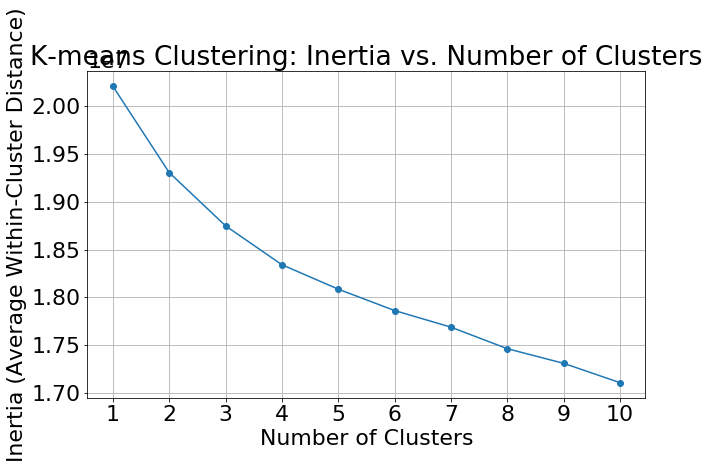

In [77]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.figure(figsize=(10, 6))
plt.plot(range_clusters, inertia, marker='o')
plt.title('K-means Clustering: Inertia vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Average Within-Cluster Distance)')
plt.xticks(range_clusters)
plt.grid()
plt.show()

In [78]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

n_clusters = 10
inertia = []

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(scaled_data)
inertia.append(kmeans.inertia_)

In [79]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Put in code here to execute all main cleaning steps:
    
    cat_columns = [
            'Decade', 
            'Movement', 
            'Wealth', 
            'Family', 
            'ANREDE_KZ', 
            'CJT_GESAMTTYP', 
            'FINANZTYP', 
            'GFK_URLAUBERTYP', 
            'HEALTH_TYP', 
            'LP_FAMILIE_GROB', 
            'LP_STATUS_GROB', 
            'RETOURTYP_BK_S', 
            'SHOPPER_TYP'
    ]
    
    cols_to_drop = [
            'OST_WEST_KZ', 
            'CAMEO_DEUG_2015', 
            'CAMEO_DEU_2015', 
            'KBA13_ANZAHL_PKW',
            'PLZ8_ANTG1', 
            'PLZ8_ANTG2', 
            'PLZ8_ANTG3', 
            'PLZ8_ANTG4', 
            'PLZ8_BAUMAX',
            'PLZ8_HHZ', 
            'PLZ8_GBZ', 
            'GEBAEUDETYP_RASTER', 
            'MOBI_REGIO', 
            'GEBAEUDETYP_RASTER',
            'BALLRAUM', 
            'EWDICHTE', 
            'INNENSTADT', 
            'KBA05_GBZ', 
            'KBA05_ANTG4',
            'KBA05_ANTG3', 
            'KBA05_ANTG2', 
            'KBA05_ANTG1', 
            'WOHNLAGE', 
            'MIN_GEBAEUDEJAHR', 
            'ANZ_HAUSHALTE_AKTIV', 
            'GEBAEUDETYP',
            'KONSUMNAEHE', 
            'SOHO_KZ', 
            'VERS_TYP', 
            'ZABEOTYP', 
            'TITEL_KZ', 
            'KK_KUNDENTYP', 
            'KBA05_BAUMAX', 
            'AGER_TYP', 
            'GEBURTSJAHR', 
            'LP_LEBENSPHASE_FEIN', 
            'LP_LEBENSPHASE_GROB', 
            'LP_FAMILIE_FEIN', 
            'LP_STATUS_FEIN', 
            'NATIONALITAET_KZ', 
            'GEBAEUDETYP', 
            'SEMIO_DOM', 
            'SEMIO_ERL', 
            'SEMIO_FAM', 
            'SEMIO_KAEM', 
            'SEMIO_KRIT', 
            'SEMIO_KULT', 
            'SEMIO_LUST', 
            'SEMIO_MAT', 
            'SEMIO_PFLICHT', 
            'SEMIO_RAT', 
            'SEMIO_REL', 
            'SEMIO_SOZ', 
            'SEMIO_TRADV', 
            'SEMIO_VERT'
    ]
    
    gender_map = {1: 'Male',
                  2: 'Female'}
    advert_map = {1: 'Advertising- and Consumptionminimalist',
                  2: 'Advertising- and Consumptiontraditionalist',
                  3: 'advertisinginterested Store-shopper',
                  4: 'advertisinginterested Online-shopper',
                  5: 'Advertising- and Cross-Channel-Enthusiast',
                  6: 'Advertising-Enthusiast with restricted Cross-Channel-Behaviour'}
    financial_map = {1: 'low financial interest (MINIMALIST)',
                     2: 'money-saver (SPARER)',
                     3: 'home ownership (HAUSBAUER)',
                     4: 'be prepared (VORSORGER)',
                     5: 'investor (ANLEGER)',
                     6: 'inconspicuous (UNAUFFAELLIGER)'}
    vacation_map = {1: 'Event travelers',
                    2: 'Family-oriented vacationists',
                    3: 'Winter sportspeople',
                    4: 'Culture lovers',
                    5: 'Nature fans',
                    6: 'Hiker',
                    7: 'Golden ager',
                    8: 'Homeland-connected vacationists',
                    9: 'Package tour travelers',
                    10: 'Connoisseurs',
                    11: 'Active families',
                    12: 'Without vacation'}
    health_map = {1: 'critical reserved',
                  2: 'sanitary affine',
                  3: 'jaunty hedonists'}
    family_rough_map = {1: 'single',
                        2: 'couple',
                        3: 'single parent',
                        4: 'family',
                        5: 'multiperson household'}
    social_status_map = {1: 'low-income',
                         2: 'average',
                         3: 'independents',
                         4: 'houseowners',
                         5: 'top earners'}
    return_map = {1: 'influenceable',
                  2: 'demanding',
                  3: 'incentive-receptive',
                  4: 'conservative',
                  5: 'determined'}
    shopper_map = {0: 'external supplied hedonists',
                   1: 'Shopping-stressed',
                   2: 'family-shopper',
                   3: 'demanding shopper'}

    decade_map = {1.0: '40s',
                  2.0: '50s',
                  3.0: '60s',
                  4.0: '70s',
                  5.0: '80s',
                  6.0: '90s'}
    movement_map = {0.0: 'mainstream',
                    1.0: 'avantgarde'}
    wealth_map = {1.0: 'Wealthy Households',
                  2.0: 'Prosperous Households',
                  3.0: 'Comfortable Households',
                  4.0: 'Less Affluent Households',
                  5.0: 'Poorer Households'}
    family_map = {1.0: 'Pre-Family Couples & Singles',
                  2.0: 'Young Couples With Children',
                  3.0: 'Families With School Age Children',
                  4.0: 'Older Families &  Mature Couples',
                  5.0: 'Elders In Retirement'}
    
    # convert missing value codes into NaNs, ...
    
    df.replace(unknown_chars, np.nan, inplace=True)
    df['ALTERSKATEGORIE_GROB'].replace(0, np.nan, inplace=True)
    df['ANREDE_KZ'].replace(0, np.nan, inplace=True)
    df['CJT_GESAMTTYP'].replace(0, np.nan, inplace=True)
    df['HEALTH_TYP'].replace(0, np.nan, inplace=True)
    df['LP_FAMILIE_GROB'].replace(0, np.nan, inplace=True)
    df['PRAEGENDE_JUGENDJAHRE'].replace(0, np.nan, inplace=True)
    df['RETOURTYP_BK_S'].replace(0, np.nan, inplace=True)
    df['ALTER_HH'].replace(0, np.nan, inplace=True)
    df['HH_EINKOMMEN_SCORE'].replace(0, np.nan, inplace=True)
    df['W_KEIT_KIND_HH'].replace(0, np.nan, inplace=True)
    df['WOHNDAUER_2008'].replace(0, np.nan, inplace=True)
    df['KKK'].replace(0, np.nan, inplace=True)
    df['REGIOTYP'].replace(0, np.nan, inplace=True)
    df['ALTER_HH'].replace(0, np.nan, inplace=True)
    df['ARBEIT'].replace(9, np.nan, inplace=True)
    df['RELAT_AB'].replace(9, np.nan, inplace=True)
    
    missing_sub = df.isnull().sum(axis=1)
    df['missing_values'] = missing_sub

    threshold = 0

    df = df.loc[missing_sub <= threshold]
    
    # remove selected columns and rows, ...
    
    df = df.loc[:, df.columns.difference(cols_to_drop)]
    #df.drop(columns=cols_to_drop, axis=1)

    # Decode the new variables created from PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 so they can be re-encoded using OneHotEncoder
    
    df['Decade'] = df['PRAEGENDE_JUGENDJAHRE']
    df['Decade'].replace([1, 2], 1, inplace=True)
    df['Decade'].replace([3, 4], 2, inplace=True)
    df['Decade'].replace([5, 6, 7], 3, inplace=True)
    df['Decade'].replace([8, 9], 4, inplace=True)
    df['Decade'].replace([10, 11, 12, 13], 5, inplace=True)
    df['Decade'].replace([14, 15], 6, inplace=True)
    df['Movement'] = df['PRAEGENDE_JUGENDJAHRE']
    df['Movement'].replace([1, 3, 5, 8, 10, 12, 14], 0, inplace=True)
    df['Movement'].replace([2, 4, 6, 7, 9, 11, 13, 15], 1, inplace=True)

    df['Wealth'] = df['CAMEO_INTL_2015']
    df['Wealth'].replace(['11', '12', '13', '14', '15'], 1, inplace=True)
    df['Wealth'].replace(['21', '22', '23', '24', '25'], 2, inplace=True)
    df['Wealth'].replace(['31', '32', '33', '34', '35'], 3, inplace=True)
    df['Wealth'].replace(['41', '42', '43', '44', '45'], 4, inplace=True)
    df['Wealth'].replace(['51', '52', '53', '54', '55'], 5, inplace=True)
    df['Family'] = df['CAMEO_INTL_2015']
    df['Family'].replace(['11', '21', '31', '41', '51'], 1, inplace=True)
    df['Family'].replace(['12', '22', '32', '42', '52'], 2, inplace=True)
    df['Family'].replace(['13', '23', '33', '43', '53'], 3, inplace=True)
    df['Family'].replace(['14', '24', '34', '44', '54'], 4, inplace=True)
    df['Family'].replace(['15', '25', '35', '45', '55'], 5, inplace=True)

    df['Decade'] = df['Decade'].map(decade_map)
    df['Movement'] = df['Movement'].map(movement_map)
    df['Wealth'] = df['Wealth'].map(wealth_map)
    df['Family'] = df['Family'].map(family_map)
    
    # Decode nominal variables before re-encoding using OneHotEncoder
    
    df['ANREDE_KZ'] = df['ANREDE_KZ'].map(gender_map)
    df['CJT_GESAMTTYP'] = df['CJT_GESAMTTYP'].map(advert_map)
    df['FINANZTYP'] = df['FINANZTYP'].map(financial_map)
    df['GFK_URLAUBERTYP'] = df['GFK_URLAUBERTYP'].map(vacation_map)
    df['HEALTH_TYP'] = df['HEALTH_TYP'].map(health_map)
    df['LP_FAMILIE_GROB'] = df['LP_FAMILIE_GROB'].map(family_rough_map)
    df['LP_STATUS_GROB'] = df['LP_STATUS_GROB'].map(social_status_map)
    df['RETOURTYP_BK_S'] = df['RETOURTYP_BK_S'].map(return_map)
    df['SHOPPER_TYP'] = df['SHOPPER_TYP'].map(shopper_map)
    
    # select, re-encode, and engineer column values.
    ohe = OneHotEncoder(sparse=True, handle_unknown='ignore')

    transform_sub = ohe.fit_transform(df[cat_columns])

    column_names = ohe.get_feature_names(cat_columns)
    
    encode_sub = pd.DataFrame.sparse.from_spmatrix(transform_sub, columns=ohe.get_feature_names(cat_columns))
    concat_sub = pd.concat([df, encode_sub], axis=1)
    
    new_cols_to_drop = ['GFK_URLAUBERTYP', 'FINANZTYP', 'CJT_GESAMTTYP', 'ANREDE_KZ', 'Decade', 'Movement', 'Wealth', 'Family', 'PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'HEALTH_TYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'RETOURTYP_BK_S', 'SHOPPER_TYP']
    
    #concat_sub.drop(columns=new_cols_to_drop, axis=1)
    concat_sub = concat_sub.loc[:, concat_sub.columns.difference(new_cols_to_drop)]

    concat_sub.dropna(inplace=True)
    concat_sub.reset_index(drop=True, inplace=True)
    df = concat_sub.copy()
    
    # Return the cleaned dataframe.
    
    return concat_sub

### Discussion 3.1: Apply Clustering to General Population

Since the Jupyter Notebook was never finishing the for loop to show the K-means clustering for the whole dataset, I dropped a lot of the features I didn't feel met the needs of my analysis, which took the total down to 48, then I ran KMeans to determine the ideal number of clusters was 4.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [80]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', engine='python', sep='\;')

In [81]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
clean_data(customers)

,ALTERSKATEGORIE_GROB,ALTER_HH,ANREDE_KZ_Female,ANREDE_KZ_Male,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,CJT_GESAMTTYP_Advertising- and Consumptionminimalist,CJT_GESAMTTYP_Advertising- and Consumptiontraditionalist,CJT_GESAMTTYP_Advertising- and Cross-Channel-Enthusiast,CJT_GESAMTTYP_Advertising-Enthusiast with restricted Cross-Channel-Behaviour,CJT_GESAMTTYP_advertisinginterested Online-shopper,CJT_GESAMTTYP_advertisinginterested Store-shopper,Decade_40s,Decade_50s,Decade_60s,Decade_70s,FINANZTYP_be prepared (VORSORGER),FINANZTYP_home ownership (HAUSBAUER),FINANZTYP_inconspicuous (UNAUFFAELLIGER),FINANZTYP_investor (ANLEGER),FINANZTYP_low financial interest (MINIMALIST),FINANZTYP_money-saver (SPARER),FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,Family_Elders In Retirement,Family_Families With School Age Children,Family_Older Families & Mature Couples,Family_Pre-Family Couples & Singles,Family_Young Couples With Children,GFK_URLAUBERTYP_Active families,GFK_URLAUBERTYP_Connoisseurs,GFK_URLAUBERTYP_Culture lovers,GFK_URLAUBERTYP_Event travelers,GFK_URLAUBERTYP_Family-oriented vacationists,GFK_URLAUBERTYP_Golden ager,GFK_URLAUBERTYP_Hiker,GFK_URLAUBERTYP_Homeland-connected vacationists,GFK_URLAUBERTYP_Nature fans,GFK_URLAUBERTYP_Package tour travelers,GFK_URLAUBERTYP_Winter sportspeople,GFK_URLAUBERTYP_Without vacation,GREEN_AVANTGARDE,HEALTH_TYP_critical reserved,HEALTH_TYP_jaunty hedonists,HEALTH_TYP_sanitary affine,HH_EINKOMMEN_SCORE,KKK,LP_FAMILIE_GROB_couple,LP_FAMILIE_GROB_family,LP_FAMILIE_GROB_multiperson household,LP_FAMILIE_GROB_single,LP_FAMILIE_GROB_single parent,LP_STATUS_GROB_average,LP_STATUS_GROB_houseowners,LP_STATUS_GROB_independents,LP_STATUS_GROB_low-income,LP_STATUS_GROB_top earners,Movement_avantgarde,Movement_mainstream,ONLINE_AFFINITAET,ORTSGR_KLS9,REGIOTYP,RELAT_AB,RETOURTYP_BK_S_conservative,RETOURTYP_BK_S_demanding,RETOURTYP_BK_S_determined,RETOURTYP_BK_S_incentive-receptive,RETOURTYP_BK_S_influenceable,SHOPPER_TYP_Shopping-stressed,SHOPPER_TYP_demanding shopper,SHOPPER_TYP_external supplied hedonists,SHOPPER_TYP_family-shopper,WOHNDAUER_2008,W_KEIT_KIND_HH,Wealth_Comfortable Households,Wealth_Less Affluent Households,Wealth_Poorer Households,Wealth_Prosperous Households,Wealth_Wealthy Households,missing_values
0,4.0,10.0,0.0,1.0,0.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,5.0,1.0,1.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,4.0,3.0,3.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0
1,4.0,10.0,1.0,0.0,0.0,2.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,5.0,1.0,2.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,4.0,1.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,9.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0
2,3.0,20.0,1.0,0.0,0.0,3.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,5.0,2.0,3.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,5.0,6.0,6.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,9.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
3,4.0,10.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,5.0,1.0,3.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,5.0,5.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4.0,6.0,1.0,0.0,0.0,1.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,5.0,3.0,1.0,2.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,8.0,4.0,5.0,

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Assuming you have two DataFrames: customer_data and general_population_data
# Step 1: Fit K-means clustering on both datasets
n_clusters = 10  # Specify the number of clusters you want
kmeans_customers = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_general_population = KMeans(n_clusters=n_clusters, random_state=42)

# Fit the models
customer_labels = kmeans_customers.fit_predict(customers)
general_population_labels = kmeans_general_population.fit_predict(concat_gen)

# Step 2: Assign cluster labels to the DataFrames
customers['Cluster'] = customer_labels
concat_gen['Cluster'] = general_population_labels

# Step 3: Calculate the proportions of each cluster
customer_cluster_counts = customers['Cluster'].value_counts(normalize=True)
general_population_cluster_counts = concat_gen['Cluster'].value_counts(normalize=True)

# Step 4: Create a DataFrame to compare the proportions
comparison_df = pd.DataFrame({
    'Customer Proportion': customer_cluster_counts,
    'General Population Proportion': general_population_cluster_counts
}).fillna(0)  # Fill NaN values with 0 for clusters that may not be present in one of the datasets

# Step 5: Display the comparison DataFrame
print(comparison_df)

In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

overrepresented_cluster = comparison_df['Customer Proportion'].idxmax()  # Get the index of the cluster with the highest proportion

overrepresented_data = customer_data[customer_data['Cluster'] == overrepresented_cluster]

summary = overrepresented_data.describe(include='all')  # This will give you a summary of all features

print(f"Characteristics of individuals in the overrepresented cluster (Cluster {overrepresented_cluster}):")
print(summary)

In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

underrepresented_cluster = comparison_df['General Population Proportion'].idxmin()  # Get the index of the cluster with the lowest proportion in customer data

underrepresented_data = customer_data[customer_data['Cluster'] == underrepresented_cluster]

summary = underrepresented_data.describe(include='all')  # This will give you a summary of all features

print(f"Characteristics of individuals in the underrepresented cluster (Cluster {underrepresented_cluster}):")
print(summary)